In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# 读取数据
df = pd.read_csv("users_combined_info_500.csv")

In [3]:
# 数据清洗

submission_counts = df['user_id'].value_counts().reset_index()
submission_counts.columns = ['user_id', 'submission_count']

# 将统计结果合并回原 DataFrame
df_with_counts = df.merge(submission_counts, on='user_id', how='left')

# 去重：保留每个 user_id 的提交记录
result_df = df_with_counts.drop_duplicates(subset=['user_id'])
result_df = result_df.reset_index(drop=True)


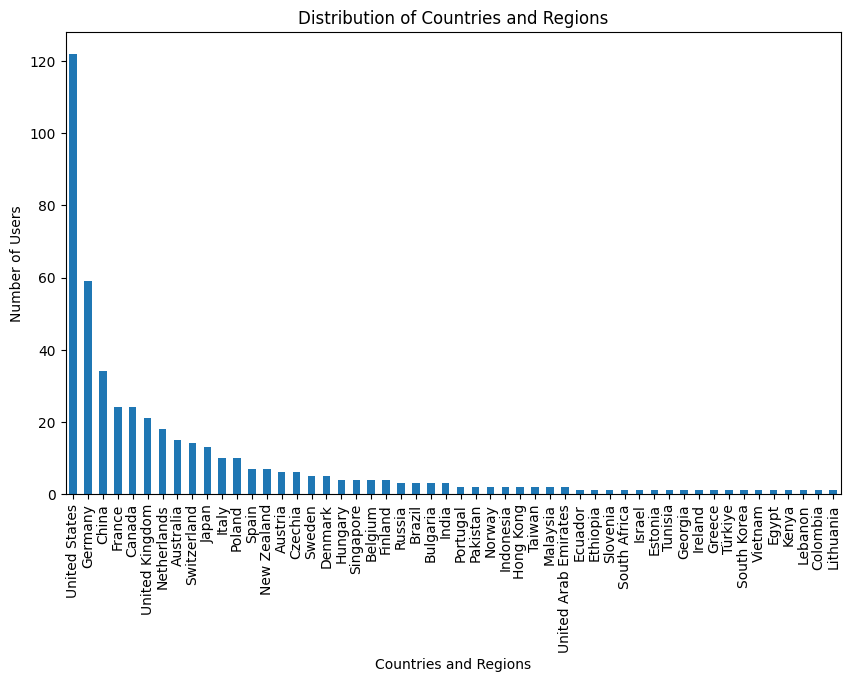

In [4]:
# 统计国家和地区分布

country_distribution = result_df['country'].value_counts()
plt.figure(figsize=(10, 6))

country_distribution.plot(kind='bar')
plt.title('Distribution of Countries and Regions')
plt.xlabel('Countries and Regions')
plt.ylabel('Number of Users')
plt.show()

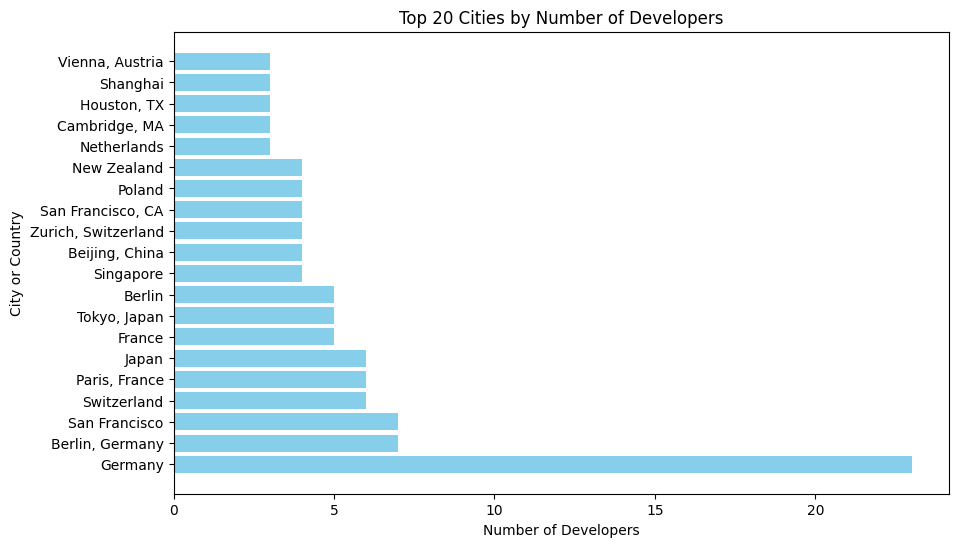

In [5]:
# 计算每个城市的开发者人数并按开发者人数排序
city_developers = result_df.groupby('location')['user_id'].nunique().reset_index()

# 对开发者人数进行排序，并选择前20个
city_developers = city_developers.sort_values(by='user_id', ascending=False).head(20)

# 绘制条形统计图
plt.figure(figsize=(10, 6))
plt.barh(city_developers['location'], city_developers['user_id'], color='skyblue')
plt.title('Top 20 Cities by Number of Developers')
plt.xlabel('Number of Developers')
plt.ylabel('City or Country')

plt.show()

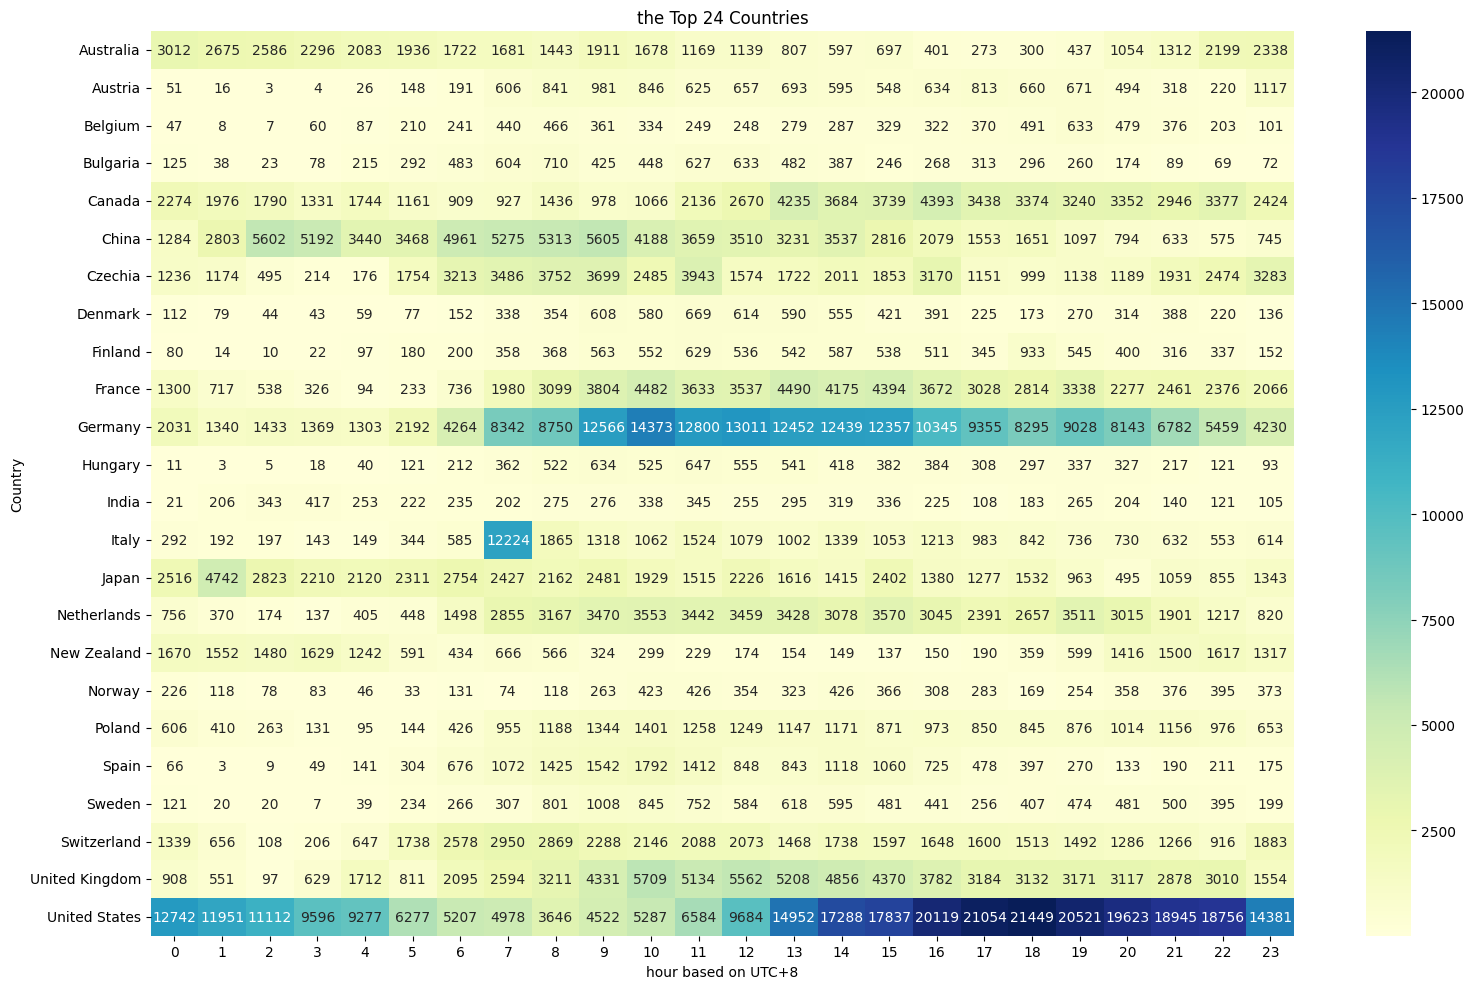

In [6]:
# 可视化时区分布
# 经查阅，时间戳已满足UTC+8时区（如 '2024-11-18 19:33:19+08:00'）
df['event_time'] = pd.to_datetime(df['event_time'])

# 提取小时信息（操作者提交的小时）
df['hour'] = df['event_time'].dt.hour

# 统计每个国家的提交总量
country_submission_total = df.groupby('country')['hour'].count().reset_index(name='submission_count')

# 选择提交总量最多的前24个国家
top_24_countries = country_submission_total.sort_values(by='submission_count', ascending=False).head(24)['country']
df_top_24 = df[df['country'].isin(top_24_countries)]

# 统计每个国家(country)每个小时(hour)的提交数量
country_hour_submission = df_top_24.groupby(['country', 'hour']).size().unstack(fill_value=0)

# 可视化为热图
plt.figure(figsize=(16, 10))
sns.heatmap(country_hour_submission, annot=True, cmap='YlGnBu', fmt='g', cbar=True)

plt.title('the Top 24 Countries')
plt.xlabel('hour based on UTC+8')
plt.ylabel('Country')
plt.tight_layout()
plt.show()

Text(154.59722222222223, 0.5, 'Submission Count after log')

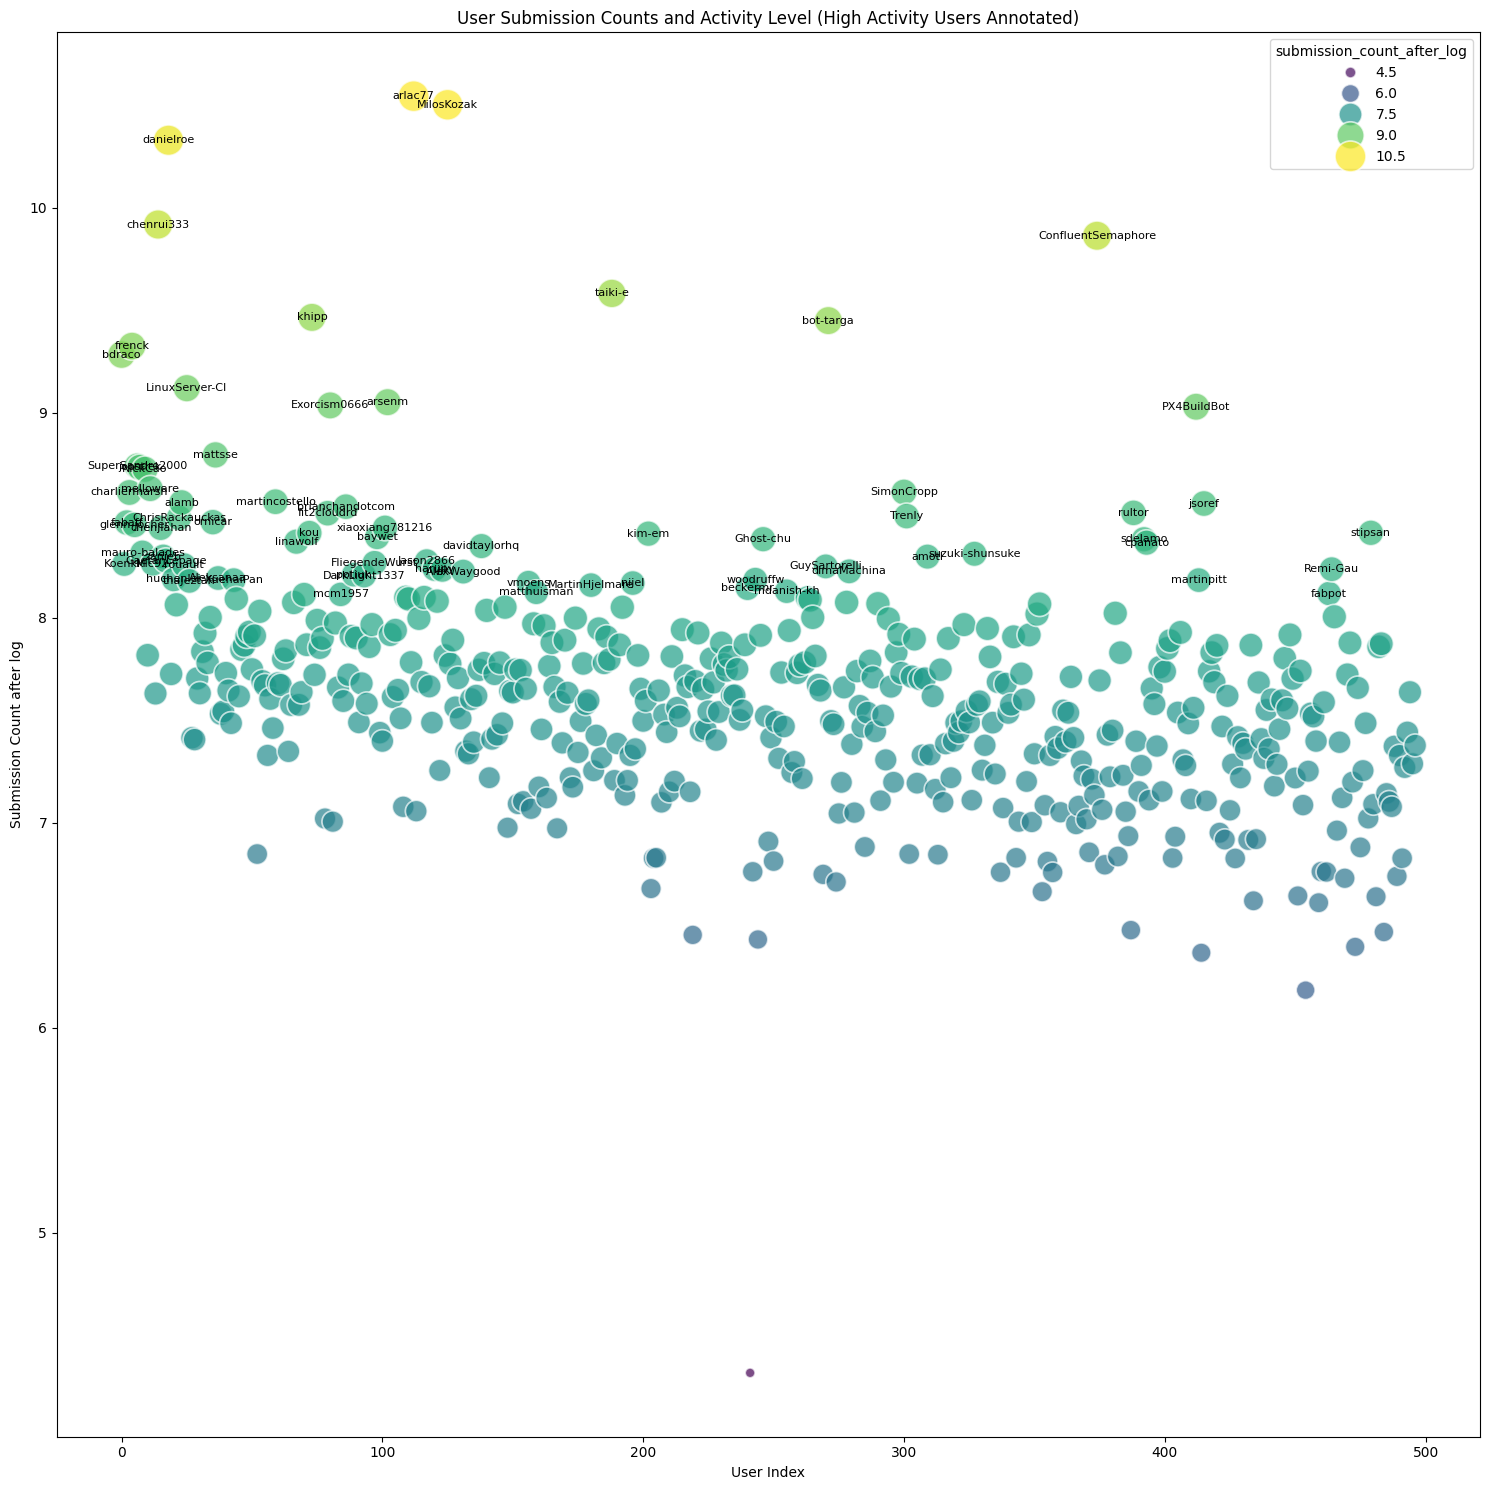

In [12]:
#提交频率

user_submission_counts = result_df[['name', 'submission_count']]
user_submission_counts = user_submission_counts.copy()
user_submission_counts['submission_count'] = np.log(user_submission_counts['submission_count'])
user_submission_counts.columns = ['name', 'submission_count_after_log']

# 识别高活跃用户和低活跃用户
high_activity_threshold = user_submission_counts['submission_count_after_log'].quantile(0.85)
low_activity_threshold = user_submission_counts['submission_count_after_log'].quantile(0.25)

# 选出高活跃用户
high_activity_users = user_submission_counts[user_submission_counts['submission_count_after_log'] > high_activity_threshold]

# 将索引作为横坐标
user_submission_counts = user_submission_counts.reset_index()


# 绘制散点图
plt.figure(figsize=(15, 15))

# 使用 Seaborn 绘制散点图，活跃度用点的大小和颜色深度表示
sns.scatterplot(x='index', y='submission_count_after_log', data=user_submission_counts,
                size='submission_count_after_log', sizes=(50, 500),  # 点的大小
                hue='submission_count_after_log', palette='viridis', alpha=0.7)

# 给高活跃用户标注名字
for i in range(len(high_activity_users)):
    plt.text(high_activity_users.index[i], high_activity_users['submission_count_after_log'].iloc[i],
             high_activity_users['name'].iloc[i], fontsize=8, ha='center', va='center', color='black')

plt.title('User Submission Counts and Activity Level (High Activity Users Annotated)')
plt.xlabel('User Index')
plt.tight_layout()
plt.ylabel('Submission Count after log')

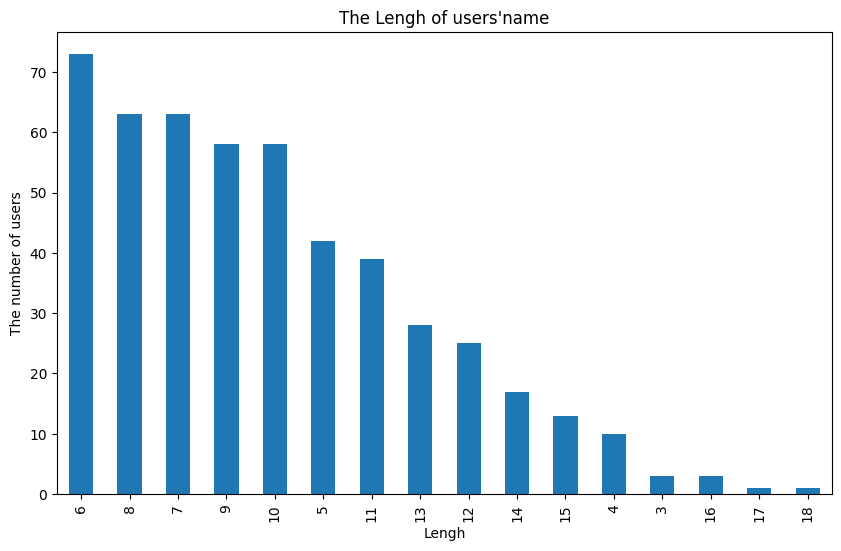

In [8]:
# 其他维度的洞察

# 1. 用户名长度分布

username_length_distribution = result_df['name'].apply(len).value_counts()

# 可视化用户名长度分布
plt.figure(figsize=(10, 6))
username_length_distribution.plot(kind='bar')
plt.title('The Lengh of users\'name')
plt.xlabel('Lengh')
plt.ylabel('The number of users')
plt.show()



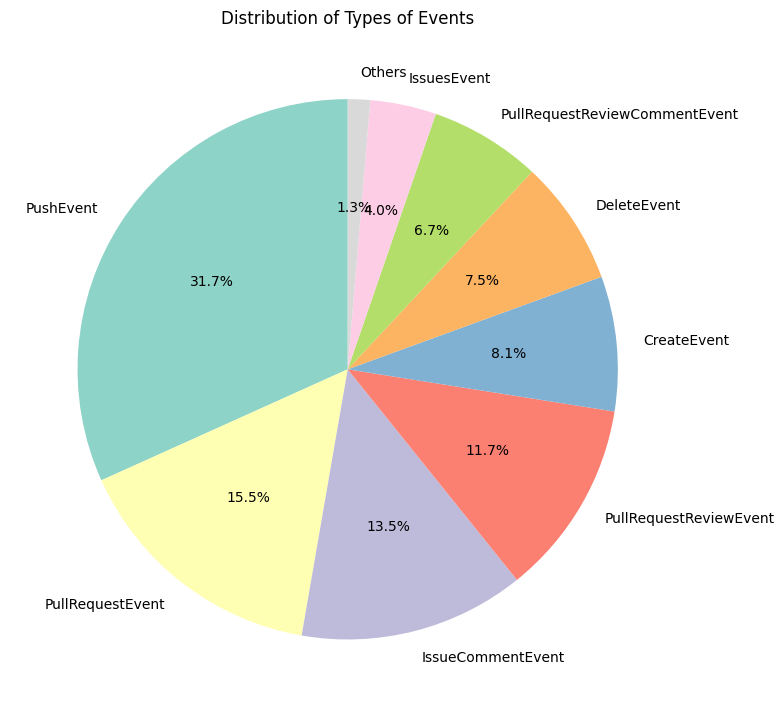

In [9]:
# 2. 事件类型分布
event_type_distribution = df['event_type'].value_counts()

# 获取前8个事件类型
top_8_event_types = event_type_distribution.head(8)

# 将剩余的事件类型归为 'Others'
others_count = event_type_distribution.iloc[8:].sum()
others_series = pd.Series({'Others': others_count})
event_type_distribution = pd.concat([top_8_event_types, others_series])

# 可视化饼图
plt.figure(figsize=(8, 8))
plt.pie(event_type_distribution, labels=event_type_distribution.index, autopct='%1.1f%%', startangle=90, colors=sns.color_palette('Set3', len(event_type_distribution)))

plt.title('Distribution of Types of Events')
plt.tight_layout()
plt.show()
